# Exercise: Tune the area under the curve

In this exercise, we'll make and compare two models using ROC curves, and tune one using the area under the curve (AUC).

The goal of our models is to identify whether each item detected on the mountain is a hiker (`true`) or a tree (`false`). We'll work with our `motion` feature here. Let's take a look:

In [2]:
import numpy as np
import pandas as pd
import graphing # custom graphing code. See our GitHub repo for details
import sklearn.model_selection

# Load our data from disk
df = pd.read_csv("hiker_or_tree.csv", delimiter="\t")

# Remove features we no longer want
del df["height"]
del df["texture"]

# Split into train and test
train, test =  sklearn.model_selection.train_test_split(df, test_size=0.5, random_state=1)

# Graph our feature
graphing.multiple_histogram(test, label_x="motion", label_group="is_hiker", nbins=12)

Motion seems associated with hikers more than trees, but not perfectly. Presumably, this is because trees blow in the wind and some hikers are found sitting down.

## A logistic regression model and a random forest

Let's train the same logistic regression model we used in the previous exercise, as well as a random-forest model. Both will try to predict which objects are hikers.

First, the logistic regression:

In [3]:
import statsmodels.api
from sklearn.metrics import accuracy_score

# This is a helper method that reformats the data to be compatible
# with this particular logistic regression model 
prep_data = lambda x:  np.column_stack((np.full(x.shape, 1), x))

# Train a logistic regression model to predict hiker based on motion
lr_model = statsmodels.api.Logit(train.is_hiker, prep_data(train.motion)).fit()

# Assess its performance
# -- Train
predictions = lr_model.predict(prep_data(train.motion)) > 0.5
train_accuracy = accuracy_score(train.is_hiker, predictions)

# -- Test
predictions = lr_model.predict(prep_data(test.motion)) > 0.5
test_accuracy = accuracy_score(test.is_hiker, predictions)

print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)
# Plot the model
predict_with_logistic_regression = lambda x: lr_model.predict(prep_data(x))
graphing.scatter_2D(test, label_x="motion", label_y="is_hiker", title="Logistic Regression", trendline=predict_with_logistic_regression)

Optimization terminated successfully.
         Current function value: 0.260202
         Iterations 8
Train accuracy 0.916
Test accuracy 0.888


Recalculate Logistic Regression using scikit-learn

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(train[['motion']], train['is_hiker'])

# Assess its performance
# -- Train
predictions = log_reg.predict(train[['motion']]) > 0.5
train_accuracy = accuracy_score(train['is_hiker'], predictions)

# Assess its performance
# -- Test
predictions = log_reg.predict(test[['motion']]) > 0.5
test_accuracy = accuracy_score(test['is_hiker'], predictions)

predict_with_log_reg_sklearn = log_reg.decision_function(test[['motion']])

graphing.scatter_2D(test, label_x="motion", label_y="is_hiker", title="Logistic Regression", trendline=predict_with_logistic_regression)
# Train and test the model
print("Logistic Regression Performance:")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

Logistic Regression Performance:
Train accuracy 0.916
Test accuracy 0.892


Now, our random-forest model:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a random forest model with 50 trees
random_forest = RandomForestClassifier(random_state=2,
                                       verbose=False)

# Train the model
random_forest.fit(train[["motion"]], train.is_hiker)

# Assess its performance
# -- Train
predictions = random_forest.predict(train[["motion"]])
train_accuracy = accuracy_score(train.is_hiker, predictions)

# -- Test
predictions = random_forest.predict(test[["motion"]])
test_accuracy = accuracy_score(test.is_hiker, predictions)


# Train and test the model
print("Random Forest Performance:")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)


Random Forest Performance:
Train accuracy 1.0
Test accuracy 0.852


These models have similar (but not identical) performance on the test set in terms of accuracy.

## Create ROC plots

Let's create ROC curves for these models. To do this, we'll simply import code from the last exercises so that we can focus on what we want to learn here. If you need a refresher on how these were made, reread the last exercise.

Note that we've made a slight change. Now our method produces both a graph and the table of numbers we used to create the graph.

First, let's look at the logistic regression model:

In [7]:
from m2d_make_roc import create_roc_curve # import our previous ROC code

fig, thresholds_lr = create_roc_curve(predict_with_logistic_regression, test, "motion")

# Uncomment the line below if you would like to see the area under the curve
#fig.update_traces(fill="tozeroy")

fig.show()

# Show the table of results
thresholds_lr

,threshold,fpr,tpr
0,-0.000001,1.000000,1.000000
1,0.000000,1.000000,1.000000
2,0.010101,1.000000,1.000000
3,0.020202,1.000000,1.000000
4,0.030303,0.895161,0.968254
...,...,...,...
99,0.969697,0.000000,0.563492
100,0.979798,0.000000,0.539683
101,0.989899,0.000000,0.464286
102,1.000000,0.000000,0.000000


Recreate ROC curve for Logistic Regression using scikit-learn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


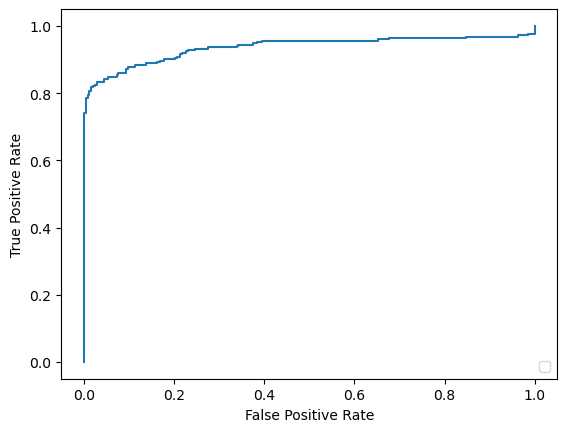

In [8]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(test['is_hiker'], log_reg.decision_function(test[['motion']]))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

We can see our model does better than chance (it's not a diagonal line). Our table shows the false positive rate (_fpr_) and true positive rate (_tpr_) for each threshold.

Let's repeat this for our random-forest model:

In [14]:
# Don't worry about this lambda function. It simply reorganizes 
# the data into the shape expected by the random forest model, 
# and calls predict_proba, which gives us predicted probabilities
# that the label is 'hiker'
predict_with_random_forest = lambda x: random_forest.predict_proba(np.array(x).reshape(-1, 1))[:,1]

# Create the ROC curve
fig, thresholds_rf = create_roc_curve(predict_with_random_forest, test, "motion")

# Uncomment the line below if you would like to see the area under the curve
fig.update_traces(fill="tozeroy")

fig.show()

# Show the table of results
thresholds_lr

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomFore

,threshold,fpr,tpr
0,-0.000001,1.000000,1.000000
1,0.000000,1.000000,1.000000
2,0.010101,1.000000,1.000000
3,0.020202,1.000000,1.000000
4,0.030303,0.895161,0.968254
...,...,...,...
99,0.969697,0.000000,0.563492
100,0.979798,0.000000,0.539683
101,0.989899,0.000000,0.464286
102,1.000000,0.000000,0.000000


## Area under the curve

Our models look quite similar. Which model do we think is best? Let's use _area under the curve_ (AUC) to compare them. We should expect a number larger than 0.5, because these models are both better than chance, but smaller than 1, because they aren't perfect.

In [15]:
from sklearn.metrics import roc_auc_score

# Logistic regression
print("Logistic Regression AUC:", roc_auc_score(test.is_hiker, predict_with_logistic_regression(test.motion)))

# Random Forest
print("Random Forest AUC:", roc_auc_score(test.is_hiker, predict_with_random_forest(test.motion)))

Logistic Regression AUC: 0.936907962109575
Random Forest AUC: 0.9306275601638505


c:\Users\Konrad\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



By a very thin margin, the logistic regression model comes out on top.

Remember, this doesn't mean the logistic regression model will always do a better job than the random forest. It means that the logistic regression model is a slightly better choice for this kind of data, and probably is marginally less reliant on having the perfect decision thresholds chosen.

## Decision Threshold Tuning

We can also use our ROC information to find the best thresholds to use. We'll just work with our random-forest model for this part.

First, let's take a look at the rate of True and False positives with the default threshold of 0.5:

In [16]:
# Print out its expected performance at the default threshold of 0.5
# We previously obtained this information when we created our graphs
row_of_0point5 = thresholds_rf[thresholds_rf.threshold == 0.5]
print("TPR at threshold of 0.5:", row_of_0point5.tpr.values[0])
print("FPR at threshold of 0.5:", row_of_0point5.fpr.values[0])

TPR at threshold of 0.5: 0.8611111111111112
FPR at threshold of 0.5: 0.15725806451612903


We can expect that, when real hikers are seen, we have an 86% chance of identifying them. When trees or hikers are seen, we have a 16% chance of identifying them as a hiker.

Let's say that for our particular situation, we consider obtaining true positive just as important as avoiding a false positive. We don't want to ignore hikers on the mountain, but we also don't want to send our team out into dangerous conditions for no reason. 

We can find the best threshold by making our own scoring system and seeing which threshold would get the best result:

In [17]:
# Calculate how good each threshold is from our TPR and FPR. 
# Our criteria is that the TPR is as high as possible and 
# the FPR is as low as possible. We consider them equally important
scores = thresholds_rf.tpr - thresholds_rf.fpr

# Find the entry with the lowest score according to our criteria
index_of_best_score = np.argmax(scores)
best_threshold = thresholds_rf.threshold[index_of_best_score]
print("Best threshold:", best_threshold)

# Print out its expected performance
print("TPR at this threshold:", thresholds_rf.tpr[index_of_best_score])
print("FPR at this threshold:", thresholds_rf.fpr[index_of_best_score])

Best threshold: 0.7373737373737375
TPR at this threshold: 0.8333333333333334
FPR at this threshold: 0.036290322580645164


Our best threshold, with this criteria, is 0.74, not 0.5! This would have us still identify 83% of hikers properly—a slight decrease from 86%—but only misidentify 3.6% of trees as hikers.

If you'd like, play with how we're calculating our scores here, and see how the threshold is adjusted.

## Summary

That's it! Here we've created ROC curves for two different models, using code we wrote in the previous exercise.

Visually, they were quite similar, and when we compared them using the area-under-the-curve metric we found that the logistic regression model was marginally better performing.

We then used the ROC curve to tune our random-forest model, based on criteria specific to our circumstances. Our very simple criteria of `TPR - FPR` let us pick a threshold that was right for us.